In [1]:
import numpy as np
from numpy import save
from numpy import load
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import lava.lib.dl.slayer as slayer
from tqdm import tqdm
import os
from loss import DECOLLELoss
from assistant import HybridAssistant
from torch.nn.functional import one_hot

### Change these for your personal folder of weights.

cwd = os.getcwd() # current working directory of the notebook
file_path = cwd+"\\EXPERIMENTS\\Network_Weights\\"
files = os.listdir(file_path)
files_paths = [file_path+i for i in files]

In [2]:
class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes,
                 n_class, stdp_block_idx, stdp_learning_rate,
                 stdp_tau_combined, burn_in=0):

        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes

        assert stdp_block_idx < len(layer_sizes), 'STDP block position exceeds the number of layers'
        # Defining which of the layers to not give linear readouts to.
        # Make an exception for the last layer (always has one) and ignore the
        # input layer (no weights to train there)
        self.stdp_block_idx = stdp_block_idx

        no_readouts = np.zeros(len(layer_sizes)-1)
        for i in range(len(no_readouts)):
            if i == self.stdp_block_idx and i < len(no_readouts)-1:
                no_readouts[i] = 1

        self.no_readouts = no_readouts

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Defining layers. Start with an input layer that is always the same
        # (defined separately to make dataset work)
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]

        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i],
                layer_sizes[i+1], weight_norm=False))

        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence if STDP block
        self.blocks[self.stdp_block_idx].synapse.weight.requires_grad=False

        #TODO: Figure out the batch norm thing if possible


        # Defining random readouts for each layer, unless specifically ignored
        readout_layers = []
        for layer_size, no_readout in zip(layer_sizes[1:], self.no_readouts):
            if not no_readout:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False

    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers linear readout layers as well. Gradient descent is only
        # performed on the blocks for which we have a linear readout on the
        # output, therefore not having a readout for the STDP block means
        # gradient updates are not performed there.

        spike.requires_grad_()
        gd_spikes = [] # used for gradient descent
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # Only keeping track of spikes for layers where we want to perform
            # backprop (makes getting readouts easier)
            if not i == self.stdp_block_idx:
                gd_spikes.append(spike)

            all_spikes.append(spike)
            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))

        for readout_layer, spike in zip(self.readout_layers, gd_spikes):
            # Getting a linear readout of the layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return all_spikes, readouts, voltages, spike_counts

    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0

    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in]

    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')

    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))

In [3]:
np.random.seed(0)

n_train = 2500 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper

layer_sizes = [50, 500, 50, 2500] # These are same as the original

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

stdp_learning_rate = 0.002 # See my message
stdp_tau_combined = -.6    # See my message
stdp_block_idx = 2  # The index of the block on which STDP will be performed (3 blocks total)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')


gloscores = {}

for index, file in enumerate(files_paths):
    print(file)
    filename = files[index]
    expansion = filename.split("_")[1]
    if len(filename.split("_")) > 3:
        epoch = int(filename.split("_")[-1][0:-3])
        name = f"epoch{epoch:02} expansion{expansion}"
    else:
        epoch = 30
        name = f"epoch{epoch:02} expansion{expansion}"
        
    file_contents = torch.load(file)
    expansion_block = file_contents['blocks.2.synapse.weight']

    layer_sizes = [50, 500, 50, len(expansion_block)] # These are same as the original

    hybrid_network = HybridNetwork(layer_sizes, n_class, stdp_block_idx, stdp_learning_rate, stdp_tau_combined, burn_in=50).to(device)
    hybrid_network.load_state_dict(torch.load(file))

    first_block = np.squeeze(hybrid_network.blocks[0].synapse.weight.data.cpu().numpy())
    OR_assignment = [np.argmax(i) for i in first_block]
    ORN_first_three = [[i[-1], i[-2], i[-3]] for i in np.sort(first_block)]

    
    
    second_block = np.squeeze(hybrid_network.blocks[1].synapse.weight.data.cpu().numpy())
    PN_gloscores = np.zeros(len(second_block))
    for PN_index, PN in enumerate(second_block):
        # Each PN needs its own ORN ranking
        second_block_ORN_weights = second_block[PN_index]
        average_ORN_by_type = {}
        for OR_index in range(len(first_block[0])):
            # Each OR needs an average value
            total = []
            for i in range(len(OR_assignment)):
                # Each average comes from the assignment
                if OR_assignment[i] == OR_index:
                    total.append(second_block_ORN_weights[i])
            if len(total) != 0:
                average_ORN_by_type[OR_index] = sum(total)/len(total)
            else:
                average_ORN_by_type[OR_index] = 0
        # Sort the averages so we can take the last two
        sorted_averages = sorted(average_ORN_by_type.items(), key = lambda x: x[1])
        weight_1 = sorted_averages[-1][1]
        weight_2 = sorted_averages[-2][1]
        PN_gloscores[PN_index] = (weight_1-weight_2)/(weight_1+weight_2)
    gloscores[name] = np.average(PN_gloscores)
    sorted_gloscores = dict(sorted(gloscores.items(), key = lambda x: x[0]))

C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_0.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_1.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_10.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_11.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_12.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_13.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_14.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_15.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERIMENTS\Network_Weights\network_1to100_30epochs_epoch_17.pt
C:\Users\laure\OneDrive\Notes\Year 6 - RU\EXPERI

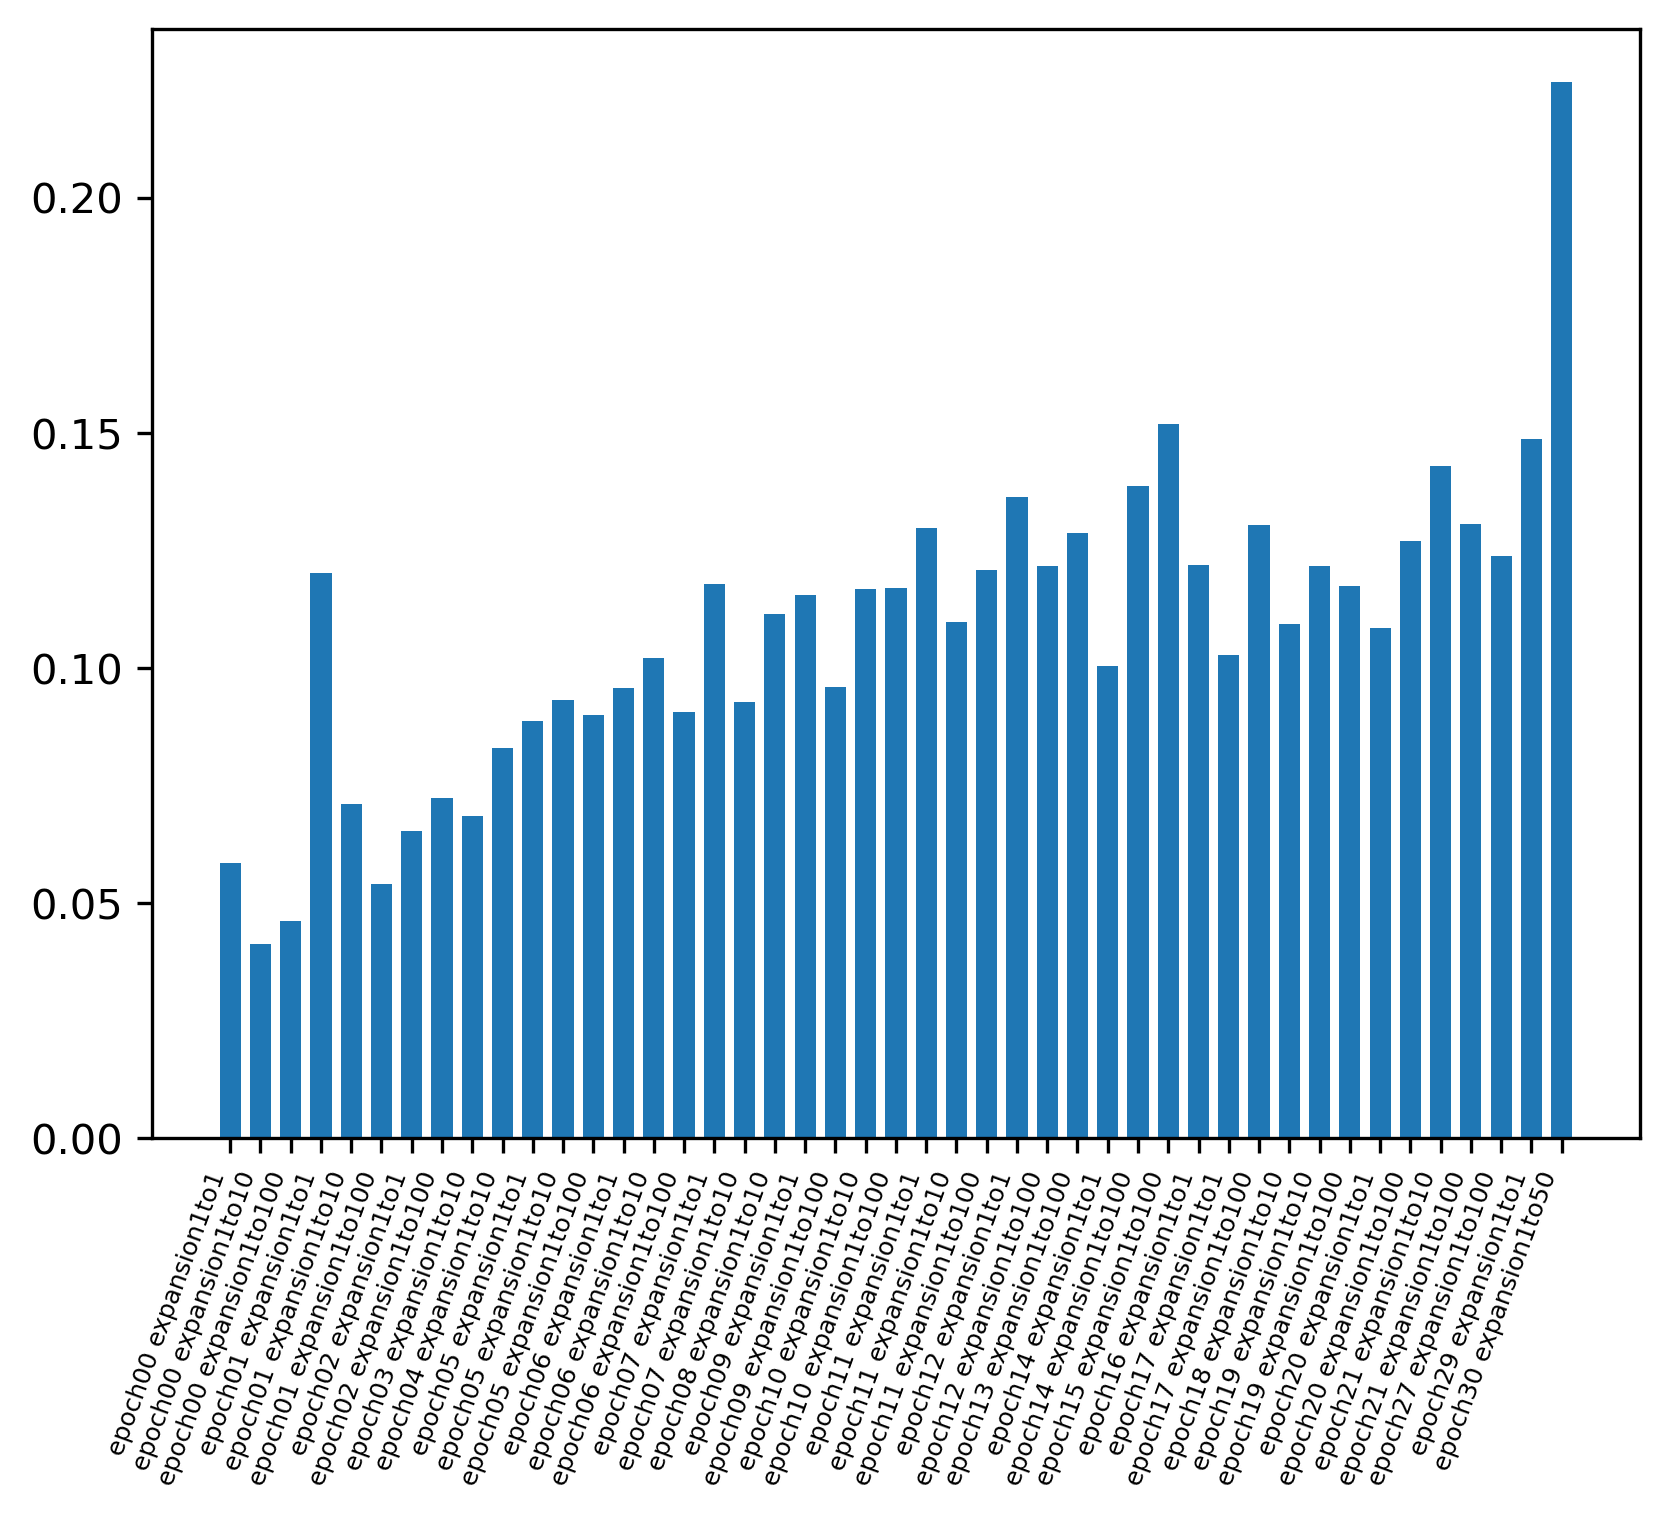

In [5]:
plt.figure()
plt.bar(range(len(sorted_gloscores)), list(sorted_gloscores.values()), align='center', width=0.7)
plt.xticks(range(len(sorted_gloscores)), list(sorted_gloscores.keys()), rotation=70, horizontalalignment='right', size=6)
plt.gcf().set_dpi(300)
plt.show()